In [1]:
# !pip install gekko
from gekko import GEKKO
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
import json
from lib import *

In [2]:
%load_ext autoreload
%autoreload 2

### Optimal Control

* $x$ - state value
* $u$ - control variable
* $t$ - time variable $\in [t_0, t_f] = N$ - time horizon

**Continuous time**: \
Cost function: $F(\cdot) = V_f(x(t_0), t_0, x(t_f), t_f) + \int\limits_{t_0}^{t_f} l(x(t), u(t), t) dt$
* State equation: $\dot{x} = f(x, u)$
* Path constraints: $h(x(t), u(t), t) \leq 0$
* Final constraint: $h_f(x(t_f)) \leq 0$


**Discrete time**: (in this case we renote: $t \in [t_0, t_f] \mapsto k \in [0, N]: x(t) = x(k)$)\
Cost function: $F(\cdot) = V_f(x(0), x(N)) + \sum\limits_{k=0}^{N} l(x(k), u(k))$
* State equation: $x^{+} = x(k+1) = f(x(k), u(k))$
* Path constraints: $h(x(k), u(k)) \leq 0$
* Final constraint: $h_f(x(N)) \leq 0$

### Mixed-Integer Optimal Control

Suppose we have
* $x \in \mathbb{R}^{n_x}$ - state variable
* $u \in \mathbb{R}^{n_u}$ - continuous control variable
* $i \in \mathbb{Z}^{n_i}$ - integer control variable inside a bounded convex polyhedron P
* Objective function $F$ consists of a nonlinear least squares term $F1$ and nonlinear term $F_2$ - both are differentiable

And lets note
* $\textbf{x} = (x(0), x(1), \dots, x(N))$
* $\textbf{u} = (u(0), u(1), \dots, u(N-1))$
* $\textbf{i} = (i(0), i(1), \dots, i(N-1))$

So we have **Mixed-Integer Optimal Control** problem ($\star$):

$
\min\limits_{\textbf{x}, \textbf{u}, \textbf{i}}
{F(\textbf{x}, \textbf{u}, \textbf{i})}, \quad
\left\{ \begin{array}{l}
x(0) = x_0 \\
x(k+1) = f(x(k), u(k), i(k)) \\
h(x(k), u(k), i(k)) \leq 0, k < N \\
h_f(x(N)) \leq 0 \\
\textbf{i} \in P \\
\textbf{i} \in \mathbb{Z}^{N \cdot n_i}
\end{array} \right.
\;\; $ and 
$
\;\; 
\left\{ \begin{array}{l}
F(\textbf{x}, \textbf{u}, \textbf{i}) = 
V_f(x(N)) + \sum\limits_{k=0}^{N} l(x(k), u(k), i(k)) \\
\left. \begin{array}{l}
l(x, u, i) = 
\frac{1}{2} \|l_1(x, u, i)\|_2^2 + l_2(x, u, i) \\
V_f(x) = 
\frac{1}{2} \|V_1(x)\|_2^2 + V_2(x)
\end{array} \right\}
\Rightarrow
F(\textbf{x}, \textbf{u}, \textbf{i}) = 
\frac{1}{2} \|F_1(x, u, i)\|_2^2 + F_2(x, u, i) \\
\end{array} \right.
$

---

**Example**

$
\begin{array}{rll}
\text{continuous time}: & 
    \dot{x}(t) = f_c(x(t), i(t)) = x^3(t) - i(t) \\
\text{discrete time}: & 
    x^{+} = x(k+1) = f(x(k), i(k)) = \text{Runge-Kutta-4}\ (f_c)
\end{array}
$

$
\text{objetive function}:
F(\textbf{x}, \textbf{i}) = \frac{1}{2} \sum\limits^{N}_{k=0} (x(k) - x_{ref})^2
$

$
P = 
\left\{ \textbf{i} \in [0, 1]^N \mid \begin{align} 
    & i(k) \geq i(k-1) - i(k-2) \\
    & i(k) \geq i(k-1) - i(k-3) 
\end{align} \right\}
$

$
\textbf{MINLP}: 
\min\limits_{\textbf{x}, \textbf{i}}
F(\textbf{x}, \textbf{i}), \quad
\text{such that} \;\;
\left\{ \begin{array}{l}
x(0) = x_0 \\
x(k+1) = f(x(k), i(k)) \\
\textbf{i} \in P \cap \mathbb{Z}^{N} \\
\end{array} \right.
$

$N = 30, \ x_0 = 0.8, \ x_{ref} = 0.7$

---
Firtsly, let's solve it ($\star$) with existing MINL optimal control solver from GEKKO:

In [3]:
# Differential equation:
def f(x, u, i):
    return x ** 3 - i

# Path inequality constraints:
def h(x, u, i):
    return x - x

# # Final inequality constraint:
# def h_f(x):
#     return x - x

# # Path cost function:
# def l(x, u):
#     return x ** 2 

# # Final cost function:
# def V_f(x):
#     return x ** 2

# Objective function
def F(x, u, i):
    return 0.5 * x ** 2

In [4]:
N = 30
time_step = 0.05
x_0 = 0.8
x_ref = 0.7

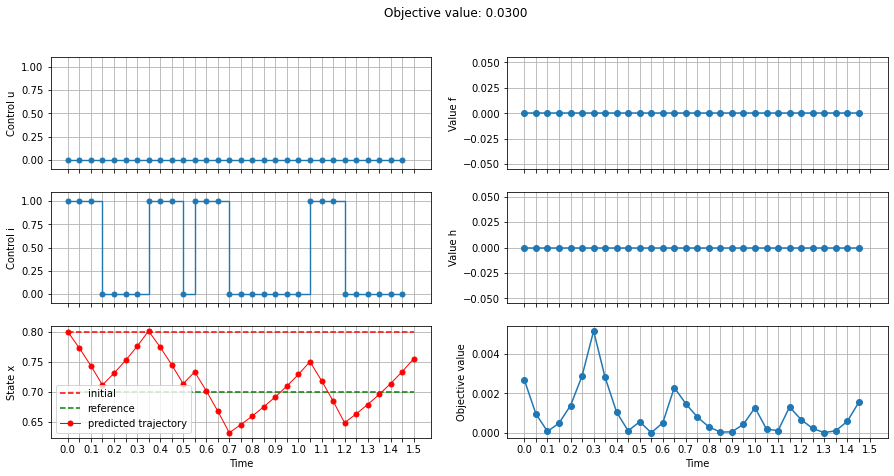

In [5]:
history_minlp = run_optimal_control(x_0, x_ref, N, time_step, f, h, F, integer=True)
show_results(history_minlp)

In [8]:
history_minlp['obj_final']

0.029990678685777906

<!-- Check that the requirement of the differential equation is met ($\dot{x}[k] = f(x[k], u[k])$)
As we can see, the requiremnt is met, so the solution is correct. -->

### Gauss-Newton algorithm

Now we can try to solve it ($\star$) with the Gauss-Newton algorithm:

**S1**: solve it without integrality constraint $\textbf{i} \in \mathbb{Z}^{n_i}$:

$
(\textbf{x}^*, \textbf{u}^*, \textbf{i}^*) = \arg\min\limits_{\textbf{x, u, i}}{F(\textbf{x, u, i})}, \quad
i \in P
$

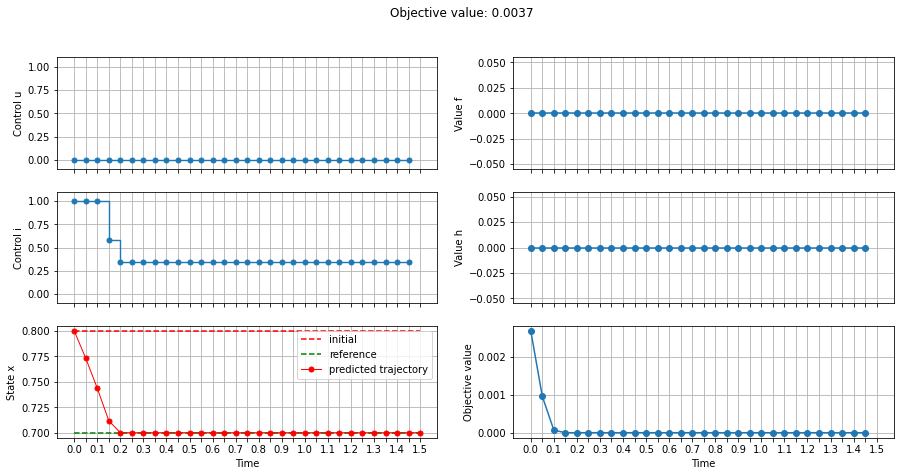

In [9]:
history_nlp = run_optimal_control(x_0, x_ref, N, time_step, f, h, F, integer=False)
show_results(history_nlp)

In [10]:
history_nlp['obj_final']

0.003693860578505914

**S2**: approximate our continuous solution by an integer one

Denote for a notation simplification:

* $z = (\textbf{x}, \textbf{u}) \in \mathbb{R}^{n_z}$, where $n_z = (N+1) \cdot n_x + N \cdot n_u$ - continuous variable
* $y = \textbf{i} \in \mathbb{R}^{n_y}$, where $n_y = N \cdot n_u$ - integer variable

then we have **Mixed-Integer Non Linear Programming** problem ($\star\star$) instead of **Mixed-Integer Non Linear Optimal Control** one ($\star$):

$
\min\limits_{y, z}{F(y, z)}, \quad
\left\{ \begin{array}{l}
G(y, z) = 0 
\;\; \text{instead of} \;
\left\{ \begin{array}{l}
x(0) = x_0 \\
x(k+1) = f(x(k), u(k), i(k))) 
\end{array} \right. \\
H(y, z) \leq 0
\;\; \text{instead of} \;
\left\{ \begin{array}{l}
h(x(k), u(k), i(k)) \leq 0, k < N \\
h_f(x(N)) \leq 0
\end{array} \right. \\
y \in P \cap \mathbb{Z}^{n_y}
\end{array} \right.
\;\; $

So, after the first step (S1) we have a continuous solution 
$(\textbf{x}^*, \textbf{u}^*, \textbf{i}^*) = (z^*, y^*)$, where $y^* = \textbf{i}^* \in P$. And we want to approximate the continuous solution $y^*$ by the integer solution $y^{**}$:

$
y^{**} = \arg\min\limits_{y}{d(y, y^*)}, \quad
y \in P \cup Z^{n_y}
$

**Proposal Gauss-Newton algorithm**:

$d(y, y^*) = J_{GN}(y \mid y^*, z^*) - J_{NLP}(y^*)$, where

$J_{GN}(y \mid y^*, z^*) = J_{QP}(y \mid y^*, z^*, B_{GN}(y^*, z^*))$, where 

$
J_{QP}(y \mid y^*, z^*, B) =
\min\limits_{z}{F_{QP}(y, z \mid y^*, z^*, B)}, \quad
\left\{ \begin{array}{l}
G_L(y, z \mid y^*, z^*) = 0 \\
H_L(y, z \mid y^*, z^*) \leq 0 \\
\end{array} \right.
$ where

* $
    B_{GN}(y^*, z^*) = 
    \frac{\partial F_1}{\partial (y, z)}(y^*, z^*)
    (\frac{\partial F_1}{\partial (y, z)}(y^*, z^*))^T
  $

* $
    F_{QP}(y, z \mid y^*, z^*, B) = 
    F_L(y, z \mid y^*, z^*) + 
    \frac{1}{2} 
    \begin{bmatrix} y - y^* \\ z - z^* \end{bmatrix}^T
    B
    \begin{bmatrix} y - y^* \\ z - z^* \end{bmatrix}
  $
* $
   F_{L}(y, z \mid y^*, z^*) = 
   F(y^*, z^*) + \frac{\partial F}{\partial (y, z)}(y^*, z^*)
   ((y, z) - (y^*, z^*))
  $
* $
   G_{L}(y, z \mid y^*, z^*) = 
   G(y^*, z^*) + \frac{\partial G}{\partial (y, z)}(y^*, z^*)
   ((y, z) - (y^*, z^*))
  $
* $
   H_{L}(y, z \mid y^*, z^*) = 
   H(y^*, z^*) + \frac{\partial H}{\partial (y, z)}(y^*, z^*)
   ((y, z) - (y^*, z^*))
  $

But in practice of working with GEKKO it will be better to return to an Optimal Control formulation:

$
\textbf{i}^{**} = 
\arg\min\limits_{\textbf{i}}{
d(\textbf{i}, \textbf{i}^{*})
}, \quad
\left\{ \begin{array}{l}
x(0) = x_0 \\
x(k+1) = f_L(x(k), u(k), i(k)) \\
h_L(x(k), u(k), i(k)) \leq 0, k < N \\
h_{fL}(x(N)) \leq 0 \\
\textbf{i} \in P \cap \mathbb{Z}^{N \cdot n_i}
\end{array} \right.
$

$
G(y, z) = 0 
\;\; \text{instead of} \;
\left\{ \begin{array}{l}
x(0) = x_0 \\
x(k+1) = f(x(k), u(k), i(k))) 
\end{array} \right.
$

It means that $G(y, z)$ looks like:

$
\left\{ \begin{array}{l}
x(0) = x_0 \\
x(1) = f(x(0), u(0), i(0))) \\
x(2) = f(x(1), u(1), i(1))) \\
\dots \\
% x(N) = f(x(N-1), u(N-1), i(N-1))) \\
\end{array} \right.
\iff
\textbf{x} = 
\begin{bmatrix}
x(0) \\ x(1) \\ x(2) \\ \dots
\end{bmatrix}
=
\begin{bmatrix}
x_0 \\
f(x(0), u(0), i(0))) \\
f(x(1), u(1), i(1))) \\
\dots \\
% f(x(N-1), u(N-1), i(N-1))) \\
\end{bmatrix}
= \textbf{f}(\textbf{x}, \textbf{u}, \textbf{i})
\Rightarrow
G(y, z) = 
G(\textbf{x}, \textbf{u}, \textbf{i}) = 
\textbf{x} - \textbf{f}(\textbf{x}, \textbf{u}, \textbf{i})
$

Thus, 
$
\frac{\partial G}{\partial (y, z)} = 
(
    \frac{\partial G}{\partial y}, 
    \frac{\partial G}{\partial z}
) = 
(
    \frac{\partial G}{\partial \textbf{i}}, 
    \frac{\partial G}{\partial \textbf{u}},
    \frac{\partial G}{\partial \textbf{x}}
) = 
(
    -\frac{\partial \textbf{f}}{\partial \textbf{i}}, 
    -\frac{\partial \textbf{f}}{\partial \textbf{u}},
    I - \frac{\partial \textbf{f}}{\partial \textbf{x}}
)
$

$
\frac{\partial \textbf{f}}{\partial \textbf{i}} = 
\big[ 
\frac{\partial \textbf{f}(k)}{\partial i(s)} 
\big]^{(N+1) \times N}
k = \overline{0, N}, s = \overline{0, N-1} \;
\Rightarrow
\frac{\partial \textbf{f}}{\partial \textbf{i}} = 
\begin{bmatrix}
0 & 0 & 0 & \dots \\
\frac{\partial f}{\partial i}(i(0)) & 0 & 0 & \dots \\
0 & \frac{\partial f}{\partial i}(i(1)) & 0 & \dots \\
0 & 0 & \frac{\partial f}{\partial i}(i(2)) & \dots \\
\dots \\
\end{bmatrix}
$

$
\frac{\partial \textbf{f}}{\partial \textbf{u}} = 
\big[ 
\frac{\partial \textbf{f}(k)}{\partial u(s)} 
\big]^{(N+1) \times N}
k = \overline{0, N}, s = \overline{0, N-1}
\Rightarrow
\frac{\partial \textbf{f}}{\partial \textbf{u}} = 
\begin{bmatrix}
0 & 0 & 0 & \dots \\
\frac{\partial f}{\partial u}(u(0)) & 0 & 0 & \dots \\
0 & \frac{\partial f}{\partial u}(u(1)) & 0 & \dots \\
0 & 0 & \frac{\partial f}{\partial u}(u(2)) & \dots \\
\dots \\
\end{bmatrix}
$

$
\frac{\partial \textbf{f}}{\partial \textbf{x}} = 
\big[ 
\frac{\partial \textbf{f}(k)}{\partial x(s)} 
\big]^{(N+1) \times (N+1)}
k = \overline{0, N}, s = \overline{0, N} \
\Rightarrow
\frac{\partial \textbf{f}}{\partial \textbf{x}} = 
\begin{bmatrix}
0 & 0 & 0 & \dots \\
\frac{\partial f}{\partial x}(x(0)) & 0 & 0 & \dots \\
0 & \frac{\partial f}{\partial x}(x(1)) & 0 & \dots \\
0 & 0 & \frac{\partial f}{\partial x}(x(2)) & \dots \\
\dots \\
\end{bmatrix}
$

Thus, 
$
d G = 
(-\frac{\partial \textbf{f}}{\partial \textbf{i}}) d \textbf{i} +
(-\frac{\partial \textbf{f}}{\partial \textbf{u}}) d \textbf{u} +
(I - \frac{\partial \textbf{f}}{\partial \textbf{x}}) d \textbf{x} 
= \\
-
\begin{bmatrix}
0 & 0 & 0 & \dots \\
\frac{\partial f}{\partial i}(i(0)) & 0 & 0 & \dots \\
0 & \frac{\partial f}{\partial i}(i(1)) & 0 & \dots \\
0 & 0 & \frac{\partial f}{\partial i}(i(2)) & \dots \\
\dots \\
\end{bmatrix} 
\begin{bmatrix}
di(0) \\ di(1) \\ di(2) \\ \dots
\end{bmatrix}
- 
\begin{bmatrix}
0 & 0 & 0 & \dots \\
\frac{\partial f}{\partial u}(u(0)) & 0 & 0 & \dots \\
0 & \frac{\partial f}{\partial u}(u(1)) & 0 & \dots \\
0 & 0 & \frac{\partial f}{\partial u}(u(2)) & \dots \\
\dots \\
\end{bmatrix} 
\begin{bmatrix}
du(0) \\ du(1) \\ du(2) \\ \dots
\end{bmatrix}
-
\begin{bmatrix}
0 & 0 & 0 & \dots \\
\frac{\partial f}{\partial x}(x(0)) & 0 & 0 & \dots \\
0 & \frac{\partial f}{\partial x}(x(1)) & 0 & \dots \\
0 & 0 & \frac{\partial f}{\partial x}(x(2)) & \dots \\
\dots \\
\end{bmatrix}
\begin{bmatrix}
dx(0) \\ dx(1) \\ dx(2) \\ \dots
\end{bmatrix}
+ 
\begin{bmatrix}
dx(0) \\ dx(1) \\ dx(2) \\ \dots
\end{bmatrix}
$

$
d G = 
-
\begin{bmatrix}
0 \\ 
\frac{\partial f}{\partial i}(i(0)) \ di(0) \\
\frac{\partial f}{\partial i}(i(1)) \ di(1) \\
\frac{\partial f}{\partial i}(i(2)) \ di(2) \\
\dots \\
\end{bmatrix}
-
\begin{bmatrix}
0 \\ 
\frac{\partial f}{\partial u}(u(0)) \ du(0) \\
\frac{\partial f}{\partial u}(u(1)) \ du(1) \\
\frac{\partial f}{\partial u}(u(2)) \ du(2) \\
\dots \\
\end{bmatrix}
-
\begin{bmatrix}
0 \\ 
\frac{\partial f}{\partial x}(x(0)) \ dx(0) \\
\frac{\partial f}{\partial x}(x(1)) \ dx(1) \\
\frac{\partial f}{\partial x}(x(2)) \ dx(2) \\
\dots \\
\end{bmatrix}
+
\begin{bmatrix}
dx(0) \\ dx(1) \\ dx(2) \\ \dots
\end{bmatrix}
$

Thus, 
$
G_{L}(y, z \mid y^*, z^*) = 
G(y^*, z^*) + \frac{\partial G}{\partial (y, z)}(y^*, z^*)((y, z) - (y^*, z^*)) = 
G^* + dG^* = \\
\underbrace{
    \begin{bmatrix}
    x^*(0) \\ x^*(1) \\ x^*(2) \\ \dots
    \end{bmatrix}
    -
    \begin{bmatrix}
    x_0 \\
    f(x^*(0), u^*(0), i^*(0))) \\
    f(x^*(1), u^*(1), i^*(1))) \\
    \dots \\
    \end{bmatrix}
}_{G^*}
\
\underbrace{
    -
    \begin{bmatrix}
    0 \\ 
    \frac{\partial f}{\partial i}(i(0)) \ (i(0) - i^*(0)) \\
    \frac{\partial f}{\partial i}(i(1)) \ (i(1) - i^*(1)) \\
    \dots \\
    \end{bmatrix}
    -
    \begin{bmatrix}
    0 \\ 
    \frac{\partial f}{\partial u}(u(0)) \ (u(0) - u^*(0)) \\
    \frac{\partial f}{\partial u}(u(1)) \ (u(1) - u^*(1)) \\
    \dots \\
    \end{bmatrix}
    -
    \begin{bmatrix}
    0 \\ 
    \frac{\partial f}{\partial x}(x(0)) \ (x(0) - x^*(0)) \\
    \frac{\partial f}{\partial x}(x(1)) \ (x(1) - x^*(1)) \\
    \dots \\
    \end{bmatrix}
    +
    \begin{bmatrix}
    (x(0) - x^*(0)) \\ 
    (x(1) - x^*(1)) \\ 
    (x(2) - x^*(2)) \\ 
    \dots
    \end{bmatrix}
}_{dG^*}
$

So, if we gonna use $G_L$ instead of $G$ in the corresponding programming problem, we should use these constraints in the original optimal control problem:
$
\left\{ \begin{array}{l}
x(0) = x_0 \\
x(k+1) = f(x^*(k), u^*(k), i^*(k))) 
+ \frac{\partial f}{\partial i}(i(k)) \ (i(k) - i^*(k))
+ \frac{\partial f}{\partial u}(u(k)) \ (u(k) - u^*(k))
+ \frac{\partial f}{\partial x}(x(k)) \ (x(k) - x^*(k))
\end{array} \right.
$

It's easy to see that the right part of the equation is the linearization of the function f:

$
\left\{ \begin{array}{l}
x(0) = x_0 \\
x(k+1) = f_L(x(k), u(k), i(k)) \mid x^*(k), u^*(k), i^*(k)))
\end{array} \right.,
\quad
f_L(x, u, i \mid x^*, u^*, i^*) =
f(x^*, u^*, i^*) +
\frac{\partial f}{\partial (x, u, i)}((x, u, i) - (x^*, u^*, i^*))
$

Obviously, there is a same situation with the inequality constraint function $H$: if we gonna use $H_L$ instead of $H$ in the programming problem, we should use $h_L, h_{F, L}$ instead of $h$ in the optimal control problem:

$
\left\{ \begin{array}{l}
h_L(x(k), u(k), i(k)) \mid x^*(k), u^*(k), i^*(k))) \leqslant 0, k < N \\
h_{F, L}(x(N)) \leqslant 0
\end{array} \right.,
\quad
\left\{ \begin{array}{l}
h_L(x, u, i \mid x^*, u^*, i^*) =
h(x^*, u^*, i^*) +
\frac{\partial h}{\partial (x, u, i)}((x, u, i) - (x^*, u^*, i^*)) \\
h_{F, L}(x \mid x^*) =
h_F(x^*, u^*, i^*) +
\frac{\partial h_F}{\partial x}(x - x^*)
\end{array} \right.,
$

In [20]:
x_nlp = history_nlp['x']
u_nlp = history_nlp['u']
i_nlp = history_nlp['i']
obj_nlp = history_nlp['obj_final']

f_L  = lambda x, x0: linear(f, x, x0)
h_L  = lambda x, x0: linear(h, x, x0)
F_QP = lambda x, x0: gauss_newton(F, F, x, x0)
F_GN = lambda x, x0: F(*x) # F_QP(x, x0) - obj_nlp

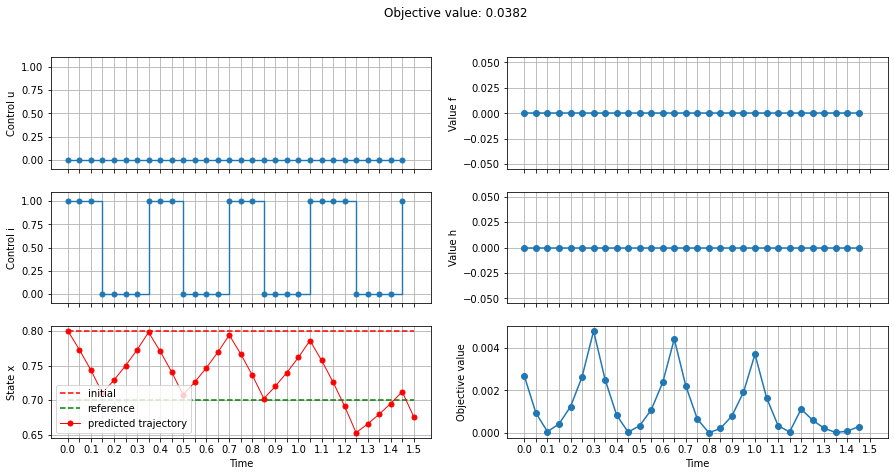

In [21]:
history_dist = run_optimal_control_dist(x_0, x_ref, x_nlp, u_nlp, i_nlp, N, time_step, f_L, h_L, F_GN)
show_results(history_dist)

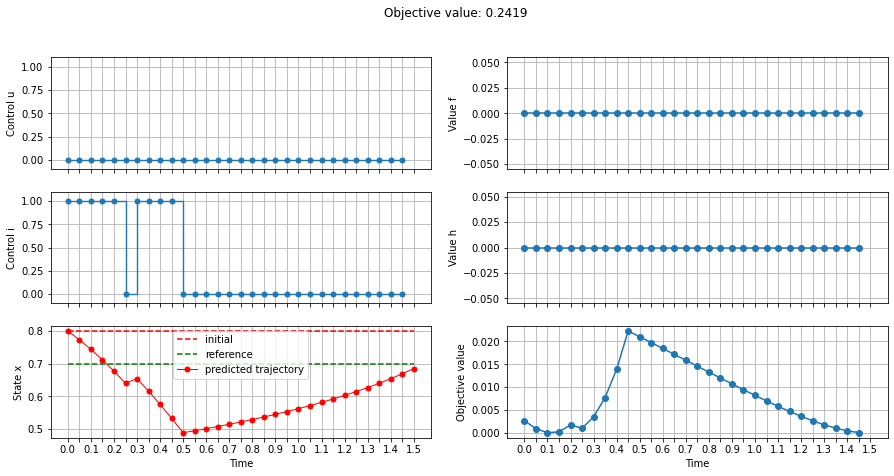

In [13]:
history_miqp = run_optimal_control(x_0, x_ref, N, time_step, f, h, F, integer=True, 
                                   const=True, const_i=history_dist['i'])
show_results(history_miqp)

In [14]:
compare_final_obj(history_minlp, history_miqp)

MIQP  solution: 0.24193
MINLP solution: 0.02999
Difference: -0.21194 - negative => MIQP is worse than MINLP


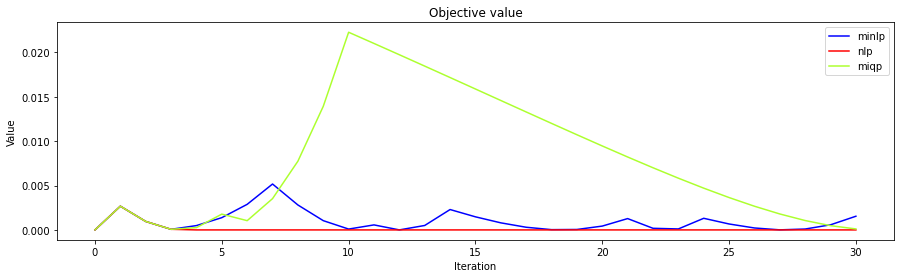

In [16]:
compare_obj_trajectory(history_minlp, history_nlp, history_dist, history_miqp)

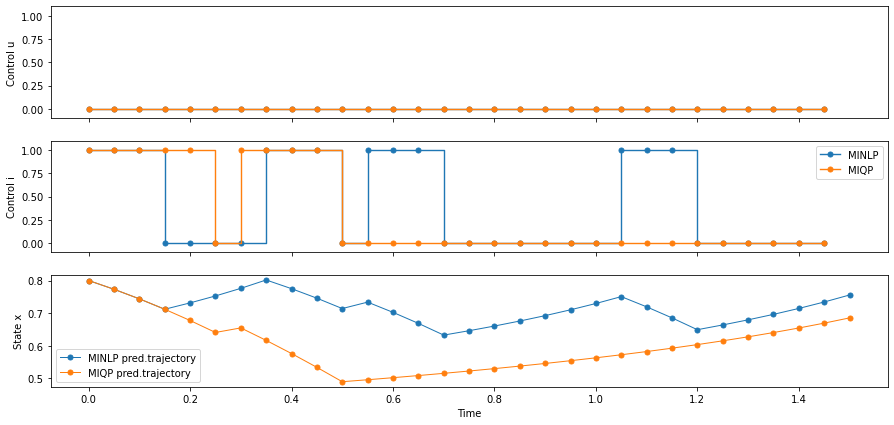

In [17]:
compare_var_trajectory(history_minlp, history_miqp)